# Projeto de portfólio - Health Insurance Cross Sell

# 0.0 Imports

In [247]:
import pandas as pd
import inflection
import numpy as np
import seaborn as sns
import random

from scipy import stats as ss

import scikitplot as skplt

import matplotlib.pyplot as plt

from sklearn import preprocessing as pp
from sklearn import model_selection as ms
from sklearn import ensemble as en
from sklearn import neighbors as nh
from sklearn import linear_model  as lm

from sklearn              import metrics          as m

from sklearn.ensemble     import RandomForestClassifier
from skopt                import forest_minimize
import xgboost            as xgb

import pickle

In [179]:
from IPython.display import Image
from IPython.core.display import HTML

## 0.1 Loading Datasets

In [180]:
df_raw = pd.read_csv("data/train.csv")

In [181]:
df_raw.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 0.2 Helper Functions

In [252]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [12, 8]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container{width:100% !important;}</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
    
def precision_at_k(x_val, yhat_model, k=2000):
    # propensity score
    x_val['score'] = yhat_model[:,1].tolist()
    # sorted clients by score
    x_val = x_val.sort_values('score', ascending=False)
    
    x_val = x_val.reset_index(drop=True)

    # creaate ranking order
    x_val['ranking'] = x_val.index+1

    x_val['precision_at_k'] = x_val['response'].cumsum()/x_val['ranking']

    return x_val.loc[k, 'precision_at_k']

def recall_at_k(x_val, yhat_model, k=2000):
    # propensity score
    x_val['score'] = yhat_model[:,1].tolist()
    # sorted clients by score
    x_val = x_val.sort_values('score', ascending=False)
    
    x_val = x_val.reset_index(drop=True)

    # creaate ranking order
    x_val['ranking'] = x_val.index+1

    x_val['recall_at_k'] = x_val['response'].cumsum()/x_val['response'].sum()

    return x_val.loc[k, 'recall_at_k']

def ml_metrics(model_name, x_val, yhat_model, k=2000):
    rec = recall_at_k(x_val, yhat_model, k=k)
    prec = precision_at_k(x_val, yhat_model, k=k)
    f1 = 2*(prec*rec)/(prec+rec)
    return pd.DataFrame({'Model Name': model_name,
                         'Recall_at_K': rec,
                         'Precision_at_K': prec,
                         'F1_score:':f1
                        }, index=[0])

def cross_validation(models_performance, num_folds, modelName, model, x_train, y_train):
    kfold=ms.StratifiedKFold(n_splits = num_folds, shuffle=True, random_state=42)
    
    precision_list = []
    recall_list = []
    f1_list = []
    roc_list = []
    
    i=1
    for train_cv,val_cv in kfold.split(x_train,y_train):

        x_train_fold = x_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]

        x_val_fold = x_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]

        model_fit = model.fit(x_train_fold,y_train_fold)

        yhat_model = model_fit.predict_proba(x_val_fold)
        
        x_val_fold['response'] = y_val_fold
        precision = round(precision_at_k(x_val_fold, yhat_model),3)
        recall= round(recall_at_k(x_val_fold, yhat_model),3)
        f1 = round(2*(precision*recall)/(precision+recall),3)
        roc = round(m.roc_auc_score(y_val_fold,yhat_model[:,1]),3)
        
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
        roc_list.append(roc)

        i+=1
    
    precision_str = np.round(np.mean(precision_list),4).astype(str) + ' +/- ' + np.round(np.std(precision_list),4).astype(str)
    recall_str = np.round(np.mean(recall_list),4).astype(str) + ' +/- ' + np.round(np.std(recall_list),4).astype(str)
    f1_str = np.round(np.mean(f1_list),4).astype(str) + ' +/- ' + np.round(np.std(f1_list),4).astype(str)            
    auc_str = np.round(np.mean(roc_list),4).astype(str) + ' +/- ' + np.round(np.std(roc_list),4).astype(str)
    
    models_performance = models_performance.append(pd.Series([modelName, precision_str, recall_str, f1_str, auc_str], index=models_performance.columns), ignore_index=True)

    return models_performance

In [183]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


/home/romulo/Documentos/health_insurance/he-env/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


# 1.0 Data description

In [184]:
X_raw = df_raw.drop(['Response'], axis = 1)
y_raw = df_raw['Response'].copy()

x_train, x_test, y_train, y_test = ms.train_test_split(X_raw, y_raw, test_size=0.10)
df1 = pd.concat([x_train, y_train], axis = 1)

## Columns Description

- Id: Customer identifier 
- Gender: Gender of customer
- Age: Age of customer
- Driving License: 0 if customer does not have the permission for drive; 1 if customer has the permission for drive
- Region Code: Region code of customer
- Previously Insured: 0 if customer does not have a vehicle insurance; 1 if customer already has a vehicle insurance.
- Vehicle Age: Age of vehicle
- Vehicle Damage: 0 if customer never got involved in a previous vehicle damage; 1 if customer already had a vehicle damage
- Annual Premium: amount paid for health insurance to the company anualy.
- Policy sales channel: anonymous code for contact with customer.
- Vintage: time (in days) that customer bought his health assurance.
- Response: 0 if customer has no interest in product; 1 if customer has interest in product

## 1.1 Rename columns

In [185]:
cols_old = ['id', 'Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage', 'Response']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new

## 1.2 Data dimensions

In [186]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 342998
Number of columns: 12


## 1.3 Data types

In [187]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.4 Check NA

In [188]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.5 Fillout NA

## 1.6 Change types

## 1.7 Descriptive statistical

In [189]:
num_attr = df1[['age', 'annual_premium', 'vintage']]

cat_attr = df1[['driving_license', 'previously_insured', 'vehicle_damage', 'vehicle_age', 'gender', 'region_code', 'policy_sales_channel' ]]

target_attr = df1['response']

### 1.7.1 Numerical Attributes

In [190]:
# Central tendency - mean, median
ct1 = pd.DataFrame(num_attr.apply(np.mean)).T
ct2 = pd.DataFrame(num_attr.apply(np.median)).T

# Dispersion - std, min, max, range, skew e kurtosis
d1 = pd.DataFrame(num_attr.apply(np.std)).T
d2 = pd.DataFrame(num_attr.apply(min)).T
d3 = pd.DataFrame(num_attr.apply(max)).T
d4 = pd.DataFrame(num_attr.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attr.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attr.apply(lambda x: x.kurtosis())).T

# concatenate
m = pd.concat([d2, d3, d4, d1, ct1, ct2, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'std', 'mean', 'median', 'skew', 'kurtosis']

In [191]:
m

,attributes,min,max,range,std,mean,median,skew,kurtosis
0,age,20.0,85.0,65.0,15.515272,38.826384,36.0,0.672084,-0.566935
1,annual_premium,2630.0,540165.0,537535.0,17213.810909,30558.413294,31656.0,1.748629,33.202654
2,vintage,10.0,299.0,289.0,83.660489,154.418279,154.0,0.001726,-1.200514


/home/romulo/Documentos/health_insurance/he-env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/romulo/Documentos/health_insurance/he-env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/romulo/Documentos/health_insurance/he-env/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to

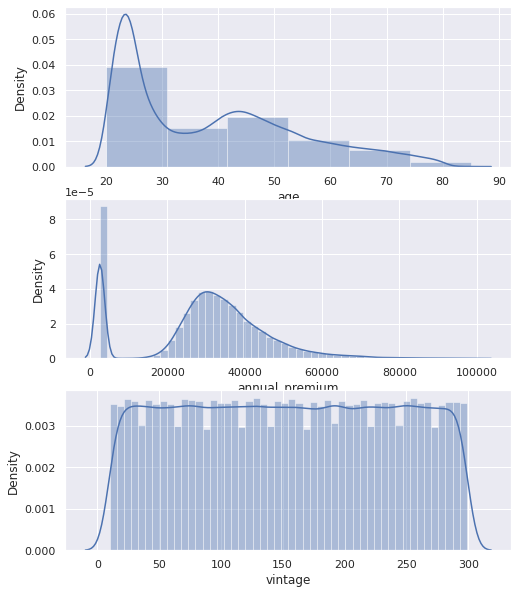

In [192]:
fig, axs = plt.subplots(3, figsize = (8,10))
sns.distplot(df1['age'], ax=axs[0], bins = 6)
sns.distplot(df1[df1['annual_premium']<100000]['annual_premium'], ax=axs[1])
sns.distplot(df1['vintage'], ax=axs[2]);

### 1.7.2 Categorical Attributes

In [193]:
cat_attr.apply(lambda x: x.unique().shape[0])

driving_license           2
previously_insured        2
vehicle_damage            2
vehicle_age               3
gender                    2
region_code              53
policy_sales_channel    154
dtype: int64

<AxesSubplot:xlabel='gender', ylabel='count'>

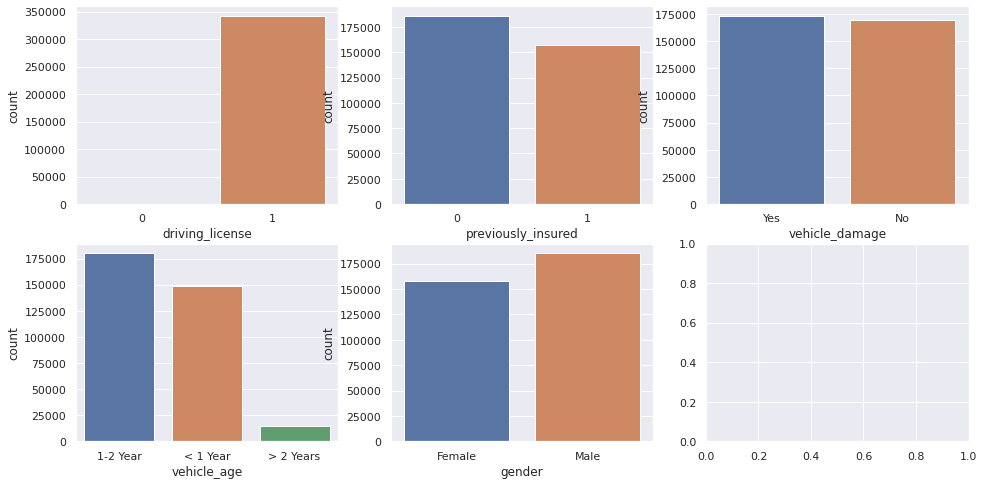

In [194]:
fig, axs = plt.subplots(ncols = 3, nrows = 2,  figsize = (16,8))

sns.countplot(x ='driving_license', data= df1, ax=axs[0][0])
sns.countplot(x = 'previously_insured', data=df1, ax=axs[0][1])
sns.countplot(x = 'vehicle_damage', data=df1, ax=axs[0][2])

sns.countplot(x = 'vehicle_age', data=df1,ax=axs[1][0])
sns.countplot(x = 'gender', data=df1,ax=axs[1][1])

## 1.7.3 Target Attribute

<AxesSubplot:xlabel='response', ylabel='count'>

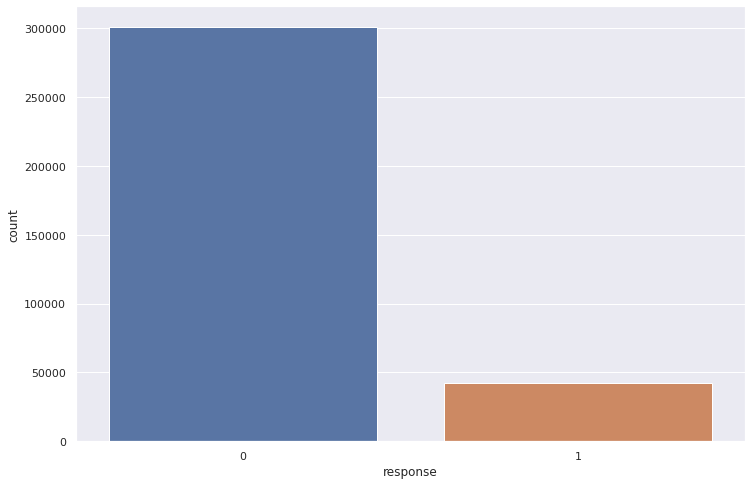

In [195]:
 sns.countplot(x = 'response', data=df1)

# 2.0 Feature Engineering

In [196]:
df2 = df1.copy()

## 2.1 Criação de hipótesis

## 2.2 Lista final de hipotesis

## 2.3 Feature engineering

In [197]:
# vehicle age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 'over_2_years' if x == '> 2 Years' else 'between_1_and_2_year' if x == '1-2 Year' else 'below_1_year')
# vehicle demage
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

# 3.0 Variables filtering

In [198]:
df3 = df2.copy()

# 4.0 Exploratory Analysis

In [199]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Numerical Attributes

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'annual_premium'}>],
       [<AxesSubplot:title={'center':'vintage'}>, <AxesSubplot:>]],
      dtype=object)

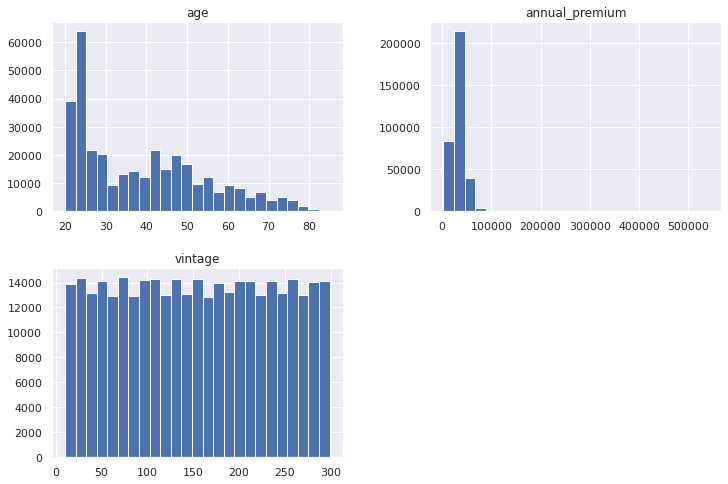

In [200]:
num_attr.hist(bins=25)

### 4.1.2 Categorical Attributes

/home/romulo/Documentos/health_insurance/he-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/romulo/Documentos/health_insurance/he-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/romulo/Documentos/health_insurance/he-env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit key

<AxesSubplot:xlabel='response', ylabel='Density'>

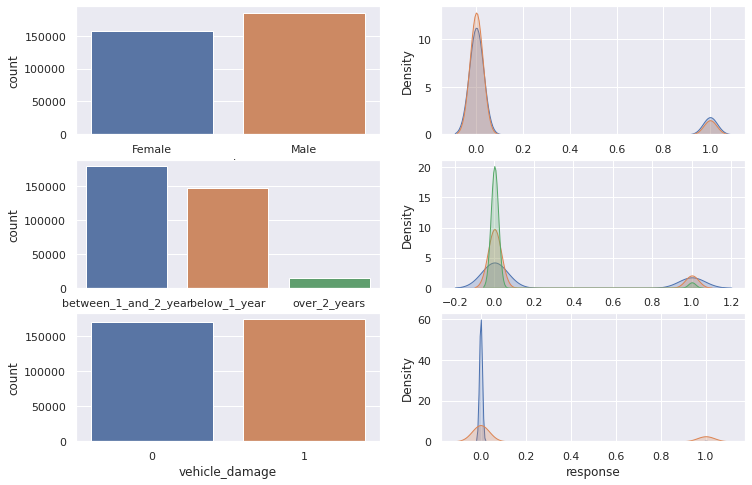

In [201]:
plt.subplot(3, 2, 1)
sns.countplot(df4['gender'])

plt.subplot(3, 2, 2)
sns.kdeplot(df4[df4['gender'] == 'Male']['response'], label='gender', shade=True)
sns.kdeplot(df4[df4['gender'] == 'Female']['response'], label='gender', shade=True)

plt.subplot(3, 2, 3)
sns.countplot(df4['vehicle_age'])

plt.subplot(3, 2, 4)
sns.kdeplot(df4[df4['vehicle_age'] == 'over_2_years']['response'], label='vehicle_age', shade=True)
sns.kdeplot(df4[df4['vehicle_age'] == 'between_1_and_2_year']['response'], label='vehicle_age', shade=True)
sns.kdeplot(df4[df4['vehicle_age'] == 'below_1_year']['response'], label='vehicle_age', shade=True)

plt.subplot(3, 2, 5)
sns.countplot(df4['vehicle_damage'])

plt.subplot(3, 2, 6)
sns.kdeplot(df4[df4['vehicle_damage'] == 0]['response'], label='vehicle_damage', shade=True)
sns.kdeplot(df4[df4['vehicle_damage'] == 1]['response'], label='vehicle_damage', shade=True)

## 4.2 Bivariete Analysis

<AxesSubplot:xlabel='age', ylabel='Count'>

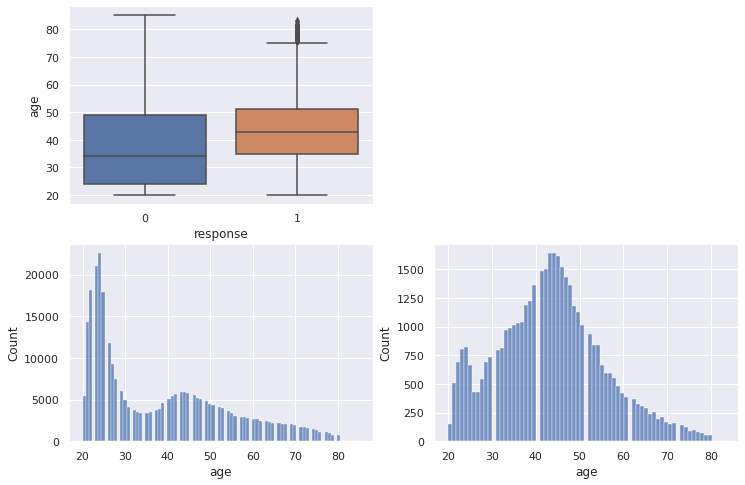

In [202]:
# age    
plt.subplot(2, 2, 1)
sns.boxplot(x='response', y='age', data=df4)

plt.subplot(2, 2, 3)
aux0 = df4.loc[df4['response'] == 0, 'age']
sns.histplot(aux0)

plt.subplot(2, 2, 4)
aux0 = df4.loc[df4['response'] == 1, 'age']
sns.histplot(aux0)

In [203]:
# driving_license
aux = df4[['response', 'driving_license']].groupby('response').sum().reset_index()
aux['driving_license_perc'] = aux['driving_license'] / aux['driving_license'].sum()
aux
#sns.barplot(x='response', y='driving_license_perc', data=aux)

,response,driving_license,driving_license_perc
0,0,300179,0.877065
1,1,42075,0.122935


<AxesSubplot:xlabel='region_code', ylabel='id'>

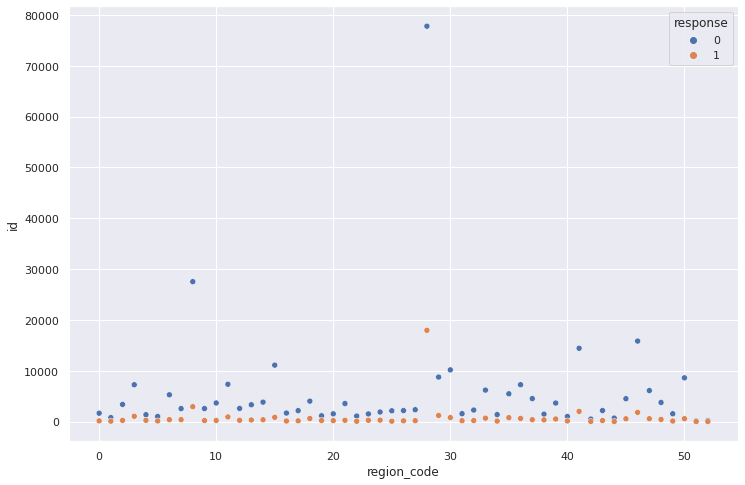

In [204]:
# region_code
aux = df4[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()
sns.scatterplot(x='region_code', y='id', hue='response', data=aux)

In [205]:
# previously_insured
pd.crosstab(df4['previously_insured'], df4['response']).apply(lambda x: x/x.sum(), axis=1)

response,0,1
previously_insured,,
0,0.774339,0.225661
1,0.999083,0.000917


In [206]:
# vehicle_age
df4[['vehicle_age', 'response']].value_counts(normalize=True).reset_index()

,vehicle_age,response,0
0,between_1_and_2_year,0,0.433857
1,below_1_year,0,0.413571
2,between_1_and_2_year,1,0.091592
3,over_2_years,0,0.029802
4,below_1_year,1,0.018846
5,over_2_years,1,0.012332


In [207]:
# vehicle_damage
pd.crosstab(df4['vehicle_damage'], df4['response']).apply(lambda x: x/x.sum(), axis=1)

response,0,1
vehicle_damage,,
0,0.994789,0.005211
1,0.762194,0.237806


<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

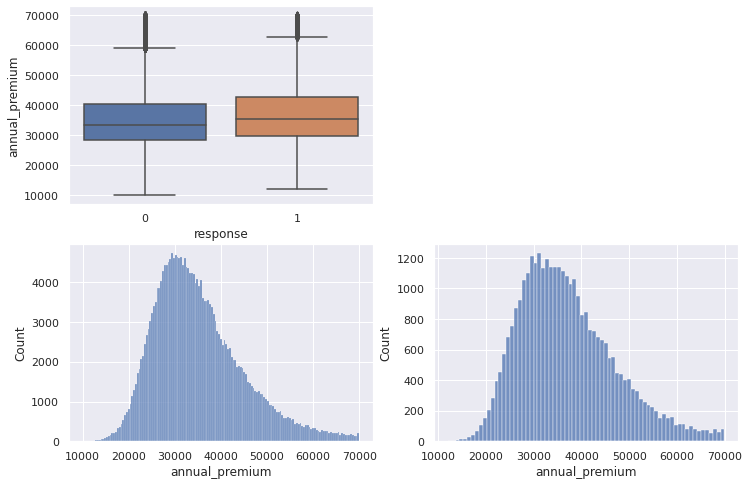

In [208]:
# annual_premium
plt.subplot(2, 2, 1)
aux = df4[(df4['annual_premium']<70000) & (df4['annual_premium'] > 10000)]
sns.boxplot(x='response', y='annual_premium', data=aux)

plt.subplot(2, 2, 3)
aux0 = aux.loc[aux['response'] == 0, 'annual_premium']
sns.histplot(aux0)

plt.subplot(2, 2, 4)
aux0 = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot(aux0)

In [209]:
# policy_sales_channel
aux = df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').sum().reset_index()
#aux.set_index('policy_sales_channel').plot(kind='bar', stacked=True, color=['steelblue', 'red'])
aux.sample(10)

,policy_sales_channel,response
11,13.0,244
12,14.0,58
3,4.0,92
139,147.0,30
80,86.0,6
55,58.0,1
53,56.0,12
46,49.0,2
73,78.0,3
151,159.0,1


<AxesSubplot:xlabel='vintage', ylabel='Count'>

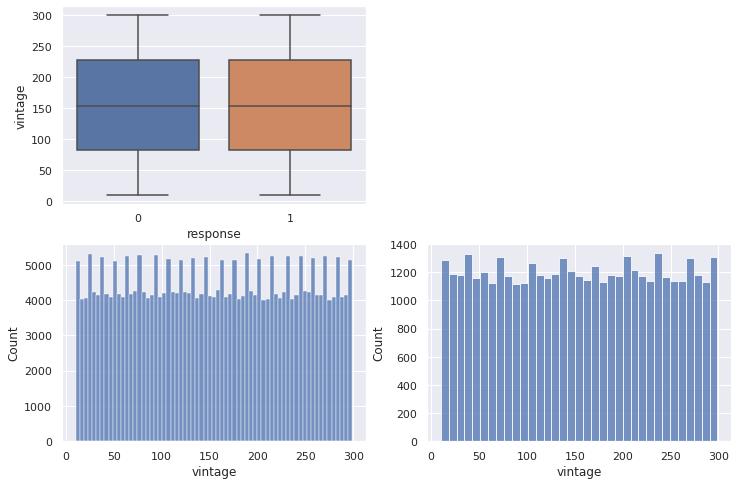

In [210]:
# vintage
plt.subplot(2, 2, 1)
sns.boxplot(x='response', y='vintage', data=df4)

plt.subplot(2, 2, 3)
aux0 = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot(aux0)

plt.subplot(2, 2, 4)
aux0 = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot(aux0)

## 4.3 Multivariate Analysis

### 4.2.1 Numerical attributes

<AxesSubplot:>

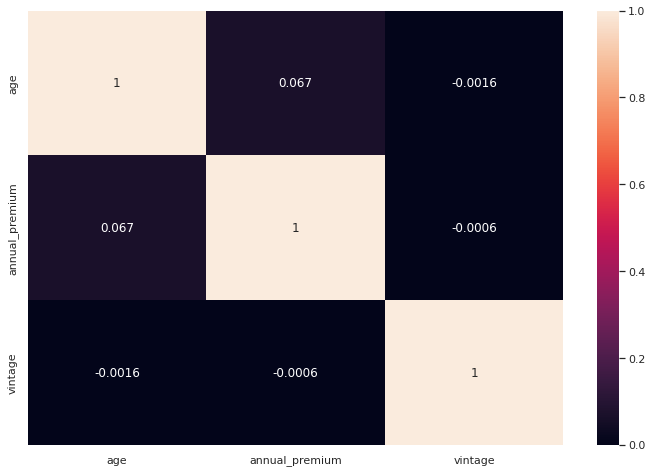

In [211]:
correlation = num_attr.corr(method='pearson')
sns.heatmap(correlation, annot=True)

### 4.2.2 Categorical attributes

In [212]:
cat_attr.columns

Index(['driving_license', 'previously_insured', 'vehicle_damage',
       'vehicle_age', 'gender', 'region_code', 'policy_sales_channel'],
      dtype='object')

In [213]:
# only categorical data
a = cat_attr

# Calculate cramver_v
a1 = cramer_v(a['gender'], a['gender'])
a2 = cramer_v(a['gender'], a['vehicle_age'])
a3 = cramer_v(a['gender'], a['vehicle_damage'])

a4 = cramer_v(a['vehicle_age'], a['gender'])
a5 = cramer_v(a['vehicle_age'], a['vehicle_age'])
a6 = cramer_v(a['vehicle_age'], a['vehicle_damage'])

a7 = cramer_v(a['vehicle_damage'], a['gender'])
a8 = cramer_v(a['vehicle_damage'], a['vehicle_age'])
a9 = cramer_v(a['vehicle_damage'], a['vehicle_damage'])

# Final dataset
d = pd.DataFrame( {'gender': [a1, a2, a3],
                   'vehicle_age': [a4, a5, a6],
                   'vehicle_damage': [a7, a8, a9]
                  } )

d = d.set_index(d.columns)

<AxesSubplot:>

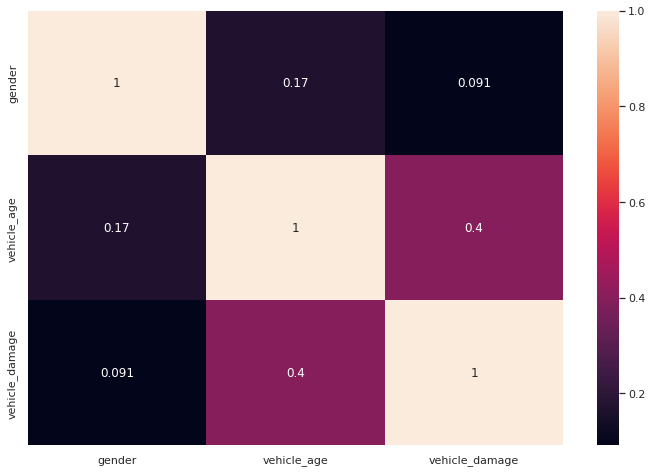

In [214]:
sns.heatmap(d, annot=True)

*vhicle_age tem uma correlação positiva interessante com vehicle_damage*
- *ou seja, quanto mais velho o veículo cresce a chance de ter sofrido danos*

# 5.0 Data preparation

In [226]:
X = df4.drop('response', axis=1)
y = df4['response'].copy()

x_train, x_val, y_train, y_val = ms.train_test_split(X, y, test_size=0.20)
#x_val_api = x_val.copy()
df5 = pd.concat([x_train, y_train], axis=1)

## 5.1 Standardization

In [227]:
ss = pp.StandardScaler()
# annual_premium
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)
pickle.dump(ss, open('/home/romulo/Documentos/health_insurance/health_insurance/src/features/annual_premium_scaler.pkl', 'wb'))

## 5.2 Rescaling

In [228]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()
# age
df5['age'] = mms_age.fit_transform(df5[['age']].values)
pickle.dump(mms_age, open('/home/romulo/Documentos/health_insurance/health_insurance/src/features/age_scaler.pkl', 'wb'))
# vintage
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)
pickle.dump(mms_vintage, open('/home/romulo/Documentos/health_insurance/health_insurance/src/features/vintage_scaler.pkl', 'wb'))

## 5.3 Transformation

### 5.3.1 Encoding

In [229]:
# driving_license -- Label encoding -- Já esta no formato
# vehicle_damage -- Label encoding -- Já esta no formato
# previously_insured -- Label encoding -- Já esta no formato

# gender -- Target Encoding
target_encode_gender = df5.groupby('gender')['response'].mean()
df5.loc[:,'gender'] = df5['gender'].map(target_encode_gender)
pickle.dump(target_encode_gender, open('/home/romulo/Documentos/health_insurance/health_insurance/src/features/gender_scaler.pkl', 'wb'))

# region_code -- Target encoding
target_encode_region_code = df5.groupby('region_code')['response'].mean()
df5.loc[:, 'region_code'] = df5['region_code'].map(target_encode_region_code)
pickle.dump(target_encode_region_code, open('/home/romulo/Documentos/health_insurance/health_insurance/src/features/region_code_scaler.pkl', 'wb'))

# vehicle_age -- One Hot Encoding / Order Encoding
df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])

# policy_sales_channel -- Frequency encoding
fe_policy_sales_channel = df5.groupby('policy_sales_channel').size() / len(df5)
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)
pickle.dump(fe_policy_sales_channel, open('/home/romulo/Documentos/health_insurance/health_insurance/src/features/policy_sales_channel_scaler.pkl', 'wb'))

## 5.4 Validation Preparation

In [230]:
# annual_premium
x_val.loc[:,'annual_premium'] = ss.fit_transform(x_val[['annual_premium']].values)

# age
x_val.loc[:, 'age'] = mms_age.fit_transform(x_val[['age']].values)

# vintage
x_val.loc[:,'vintage'] = mms_vintage.fit_transform(x_val[['vintage']].values)

# gender
x_val.loc[:, 'gender'] = x_val.loc[:,'gender'].map(target_encode_gender)

# region_code
x_val.loc[:, 'region_code'] = x_val.loc[:,'region_code'].map(target_encode_region_code)

# vehicle_age
x_val = pd.get_dummies(x_val, prefix='vehicle_age', columns=['vehicle_age'])

# policy_sales_channel
x_val.loc[:, 'policy_sales_channel'] = x_val.loc[:,'policy_sales_channel'].map(fe_policy_sales_channel)

# fillna
x_val = x_val.fillna(0)

# 6.0 Feature selection

## 6.2 Features Importance

In [41]:
# model definition
forest = en.ExtraTreesClassifier(n_estimators = 250, random_state=0, n_jobs=-1)

#data preparation
x_train_n = df5.drop(['id','response'], axis=1)
y_train_n = y_train.values
forest.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature Ranking:
                            feature  importance
0                           vintage    0.273473
0                    annual_premium    0.245088
0                               age    0.166354
0                       region_code    0.103616
0                    vehicle_damage    0.067500
0              policy_sales_channel    0.058995
0                previously_insured    0.056526
0          vehicle_age_below_1_year    0.014331
0  vehicle_age_between_1_and_2_year    0.006511
0                            gender    0.004869
0          vehicle_age_over_2_years    0.002259
0                   driving_license    0.000479


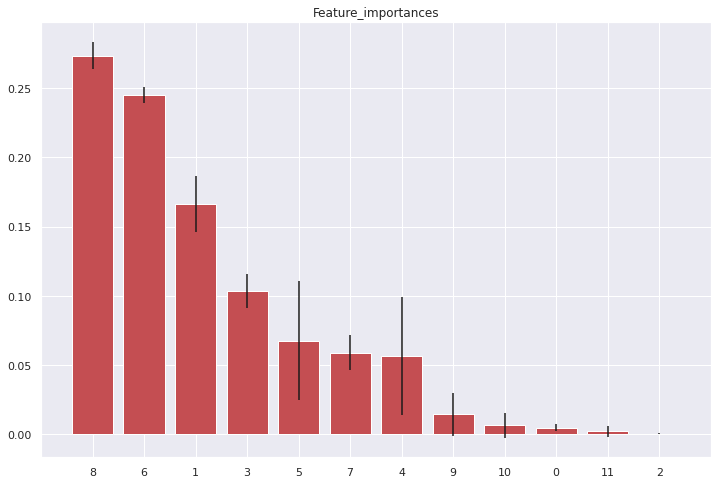

In [42]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# print the feature ranking
print("Feature Ranking:")
df = pd.DataFrame()
for i, j in zip(x_train_n, forest.feature_importances_):
    aux=pd.DataFrame({'feature':i, 'importance':j}, index=[0])
    df = pd.concat([df, aux], axis=0)

print(df.sort_values('importance', ascending=False))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature_importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim((-1, x_train_n.shape[1]))
plt.show()

# 7.0 Machine learning modeling

In [233]:
cols_selected = ['vintage','annual_premium','age','region_code','vehicle_damage', 'policy_sales_channel', 'previously_insured']

x_train = df5[cols_selected]
x_validation = x_val[cols_selected]
y_validation = y_val.copy()

## 7.1 KNN Model

In [234]:
#model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=7)

# model training
model_knn = knn_model.fit( x_train, y_train)

# model prediction - Poder de Generalização
yhat_knn = model_knn.predict_proba(x_validation)

<AxesSubplot:title={'center':'Lift Curve KNN'}, xlabel='Percentage of sample', ylabel='Lift'>

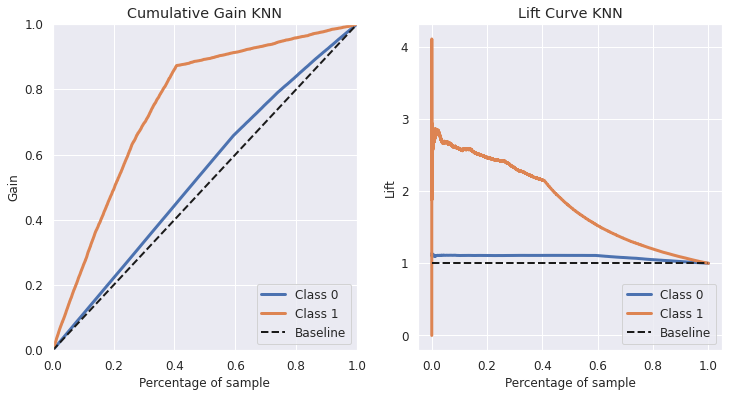

In [235]:
fig, axs = plt.subplots(ncols= 2, figsize = (12,6))
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_validation, yhat_knn, ax=axs[0], title='Cumulative Gain KNN')
# Lift Curve
skplt.metrics.plot_lift_curve(y_validation, yhat_knn, ax=axs[1], title='Lift Curve KNN')

## 7.2 Logistic Regression Model

In [236]:
# model definition
lr_model = lm.LogisticRegression(random_state=42)

# model training
lr_model.fit(x_train, y_train)

# model prediction
yhat_lr = lr_model.predict_proba(x_validation)

<AxesSubplot:title={'center':'Lift Curve Logistic Regressor'}, xlabel='Percentage of sample', ylabel='Lift'>

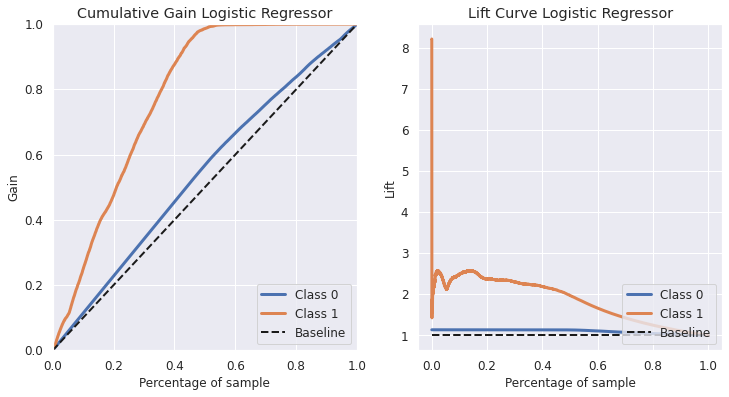

In [237]:
fig, axs = plt.subplots(ncols= 2, figsize = (12,6))
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_validation, yhat_lr, ax=axs[0], title='Cumulative Gain Logistic Regressor')
# Lift Curve
skplt.metrics.plot_lift_curve(y_validation, yhat_lr, ax=axs[1], title='Lift Curve Logistic Regressor')

## 7.3 XGBoost Classifier Model

/home/romulo/Documentos/health_insurance/he-env/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


<AxesSubplot:title={'center':'Lift Curve xgb'}, xlabel='Percentage of sample', ylabel='Lift'>

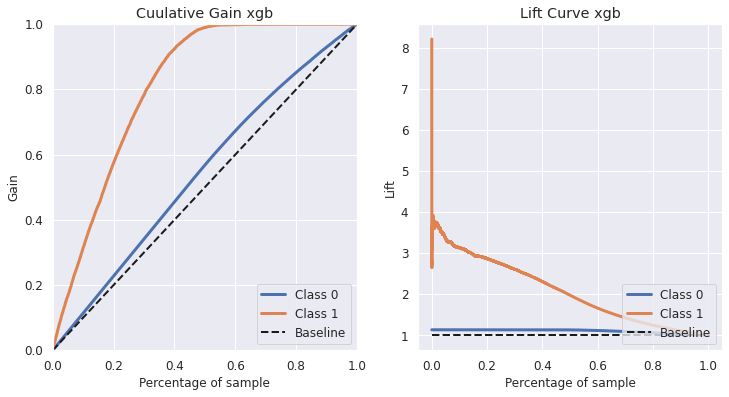

In [238]:
# model definition
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='error')
# model training
model_xgb = xgb_model.fit(x_train,y_train)
# model prediction
yhat_xgb = model_xgb.predict_proba(x_validation)

fig, axs = plt.subplots(ncols= 2, figsize = (12,6))
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_validation, yhat_xgb, ax=axs[0],title='Cumulative Gain xgb')
# Lift Curve
skplt.metrics.plot_lift_curve(y_validation, yhat_xgb,ax=axs[1],title='Lift Curve xgb')

## 7.4 Random Forest Classifier model

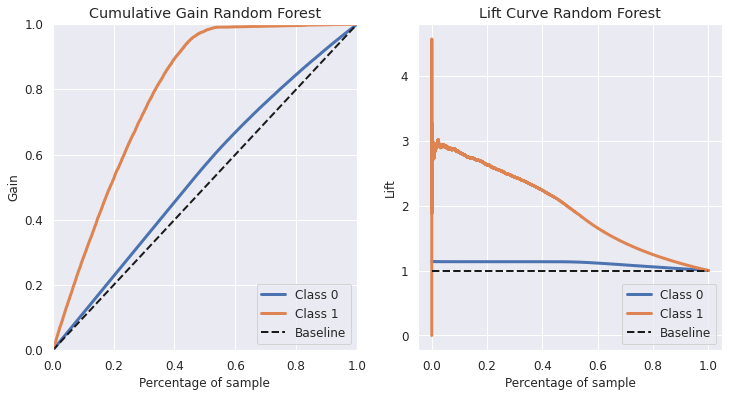

In [239]:
# model definition
rf_model = RandomForestClassifier(n_estimators=100,random_state=42)
# model training
model_rf = rf_model.fit(x_train,y_train)
# model prediction
yhat_rf = model_rf.predict_proba(x_validation)

fig, axs = plt.subplots(ncols= 2, figsize = (12,6))
# Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_validation, yhat_rf, ax=axs[0],title='Cumulative Gain Random Forest')
# Lift Curve
skplt.metrics.plot_lift_curve(y_validation, yhat_rf,ax=axs[1],title='Lift Curve Random Forest')

# 8.0 Model Performance

In [240]:
df8 = x_validation.copy()
df8['response'] = y_validation.copy()

## 8.1 KNN

In [267]:
df8_knn = df8.copy()
knn_result = ml_metrics('KNN', df8_knn, yhat_knn, k=2000)
knn_result

,Model Name,Recall_at_K,Precision_at_K,F1_score:
0,KNN,0.079899,0.333333,0.128901


## 8.2 Logistic Regression

In [264]:
df8_lr = df8.copy()
lr_result = ml_metrics('Logistic Regression', df8_lr, yhat_lr, k=2000)
lr_result

,Model Name,Recall_at_K,Precision_at_K,F1_score:
0,Logistic Regression,0.07391,0.308346,0.119239


## 8.3 XGBoost

In [265]:
df8_xgb = df8.copy()
xgb_result = ml_metrics('XGBoost Classifier', df8_xgb, yhat_xgb, k=2000)
xgb_result

,Model Name,Recall_at_K,Precision_at_K,F1_score:
0,XGBoost Classifier,0.105414,0.43978,0.170065


## 8.4 Random Forest

In [266]:
df8_rf = df8.copy()
rf_result = ml_metrics('Random Forest Classifier', df8_rf, yhat_rf, k=2000)
rf_result

,Model Name,Recall_at_K,Precision_at_K,F1_score:
0,Random Forest Classifier,0.084571,0.352824,0.136438


# 9.0 Cross Validation

In [268]:
models_performance_cv = pd.DataFrame({'Model':[], "Precision_at_k": [], "Recall_at_k": [], "F1-Score_at_k": [], "ROC_AUC_Score": []})

In [269]:
models_performance_cv = cross_validation(models_performance_cv, 5 , 'Logistic Regression CV', lr_model, x_train, y_train)
models_performance_cv = cross_validation(models_performance_cv, 5 , 'K Neighbors Classifier CV', knn_model, x_train, y_train)
models_performance_cv = cross_validation(models_performance_cv, 5 , 'Random Forest Classifier CV', rf_model, x_train, y_train)
models_performance_cv = cross_validation(models_performance_cv, 5 , 'XGBoost Classifier CV', xgb_model, x_train, y_train)

/tmp/ipykernel_3849/2718489821.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val_fold['response'] = y_val_fold
/tmp/ipykernel_3849/2718489821.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val['score'] = yhat_model[:,1].tolist()
/tmp/ipykernel_3849/2718489821.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

/tmp/ipykernel_3849/2718489821.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val_fold['response'] = y_val_fold
/tmp/ipykernel_3849/2718489821.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val['score'] = yhat_model[:,1].tolist()
/tmp/ipykernel_3849/2718489821.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

/tmp/ipykernel_3849/2718489821.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val_fold['response'] = y_val_fold
/tmp/ipykernel_3849/2718489821.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val['score'] = yhat_model[:,1].tolist()
/tmp/ipykernel_3849/2718489821.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

In [270]:
models_performance_cv.sort_values('F1-Score_at_k', ascending=False)

,Model,Precision_at_k,Recall_at_k,F1-Score_at_k,ROC_AUC_Score
3,XGBoost Classifier CV,0.4112 +/- 0.0059,0.122 +/- 0.0018,0.1884 +/- 0.0028,0.852 +/- 0.0011
2,Random Forest Classifier CV,0.3564 +/- 0.0085,0.1056 +/- 0.0026,0.1628 +/- 0.0039,0.831 +/- 0.0015
1,K Neighbors Classifier CV,0.3362 +/- 0.0072,0.0998 +/- 0.0021,0.154 +/- 0.0033,0.7794 +/- 0.001
0,Logistic Regression CV,0.2872 +/- 0.0133,0.085 +/- 0.0037,0.1312 +/- 0.0058,0.8168 +/- 0.0013


# 10. Hyperparameter Fine Tuning

## 10.1 XGBoost

In [271]:
models_performance_xgboost = pd.DataFrame({'Model':[], "Precision_at_k": [], "Recall_at_k": [], "F1-Score_at_k": [], "ROC_AUC_Score": []})

In [272]:
param = {
         'n_estimators': [1500, 1700, 2500, 3000, 3500],
         'eta': [0.01, 0.03],
         'max_depth': [3, 5, 9],
         'subsample': [0.1, 0.5, 0.7],
         'colsample_bytree': [0.3, 0.7, 0.9],
         'min_child_weight': [3, 8, 15]
        }

MAX_EVAL = 5

In [275]:
final_result = pd.DataFrame()

for i in range (MAX_EVAL):
    # choose values for parameters randomly
    hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
    print(hp)
    
    # model
    model_xgb = xgb.XGBClassifier(objective='reg:squarederror',
                                 n_estimators=hp['n_estimators'],
                                 eta=hp['eta'],
                                 max_depth=hp['max_depth'],
                                 subsample=hp['subsample'],
                                 colsample_bytee=hp['colsample_bytree'],
                                 min_child_weight=hp['min_child_weight'], n_jobs=-1)

    # performance
    # cross_validation(models_performance, num_folds, modelName, model, x_train, y_train)
    result = cross_validation(models_performance, 5, 'XGBoost Regressor', model_xgb, x_train, y_train)
    final_result = pd.concat([final_result, result])

final_result

{'n_estimators': 3500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 15}


/home/romulo/Documentos/health_insurance/he-env/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/tmp/ipykernel_3849/2718489821.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val_fold['response'] = y_val_fold
/tmp/ipykernel_3849/2718489821.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

{'n_estimators': 3000, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 8}


/tmp/ipykernel_3849/2718489821.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val_fold['response'] = y_val_fold
/tmp/ipykernel_3849/2718489821.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val['score'] = yhat_model[:,1].tolist()
/tmp/ipykernel_3849/2718489821.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.7, 'min_child_weight': 8}


/tmp/ipykernel_3849/2718489821.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val_fold['response'] = y_val_fold
/tmp/ipykernel_3849/2718489821.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val['score'] = yhat_model[:,1].tolist()
/tmp/ipykernel_3849/2718489821.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 3}


/tmp/ipykernel_3849/2718489821.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val_fold['response'] = y_val_fold
/tmp/ipykernel_3849/2718489821.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val['score'] = yhat_model[:,1].tolist()
/tmp/ipykernel_3849/2718489821.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

{'n_estimators': 1700, 'eta': 0.03, 'max_depth': 9, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 3}


/tmp/ipykernel_3849/2718489821.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val_fold['response'] = y_val_fold
/tmp/ipykernel_3849/2718489821.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val['score'] = yhat_model[:,1].tolist()
/tmp/ipykernel_3849/2718489821.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

,Model,Precision_at_k,Recall_at_k,F1-Score_at_k,ROC_AUC_Score
0,XGBoost Regressor,0.4218 +/- 0.0065,0.125 +/- 0.0021,0.1928 +/- 0.0032,0.8524 +/- 0.0014
0,XGBoost Regressor,0.423 +/- 0.0083,0.1252 +/- 0.0026,0.193 +/- 0.0039,0.8534 +/- 0.0012
0,XGBoost Regressor,0.4136 +/- 0.0015,0.1226 +/- 0.0005,0.1892 +/- 0.001,0.8492 +/- 0.0017
0,XGBoost Regressor,0.4214 +/- 0.0081,0.1252 +/- 0.0025,0.193 +/- 0.0036,0.8528 +/- 0.0015
0,XGBoost Regressor,0.3736 +/- 0.009,0.1106 +/- 0.0027,0.1706 +/- 0.0041,0.8248 +/- 0.0007


## 10.2 Final Model XGBoost Classifier

In [276]:
param_tuned = {'n_estimators': 3000, 'eta': 0.01, 'max_depth': 3, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 8}
# model
model_xgb_tuned = xgb.XGBClassifier(objective='reg:squarederror',
                             n_estimators=param_tuned['n_estimators'],
                             eta=param_tuned['eta'],
                             max_depth=param_tuned['max_depth'],
                             subsample=param_tuned['subsample'],
                             colsample_bytee=param_tuned['colsample_bytree'],
                             min_child_weight=param_tuned['min_child_weight']).fit(x_train, y_train)

/home/romulo/Documentos/health_insurance/he-env/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [277]:
models_performance_xgboost_tunned = pd.DataFrame({'Model':[], "Precision_at_k": [], "Recall_at_k": [], "F1-Score_at_k": [], "ROC_AUC_Score": []})

In [279]:
result = cross_validation(models_performance_xgboost_tunned, 5, 'XGBoost Regressor', model_xgb_tuned, x_train, y_train)
result

/home/romulo/Documentos/health_insurance/he-env/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/tmp/ipykernel_3849/2718489821.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_val_fold['response'] = y_val_fold
/tmp/ipykernel_3849/2718489821.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

,Model,Precision_at_k,Recall_at_k,F1-Score_at_k,ROC_AUC_Score
0,XGBoost Regressor,0.423 +/- 0.0083,0.1252 +/- 0.0026,0.193 +/- 0.0039,0.8534 +/- 0.0012


<AxesSubplot:title={'center':'Lift Curve Test'}, xlabel='Percentage of sample', ylabel='Lift'>

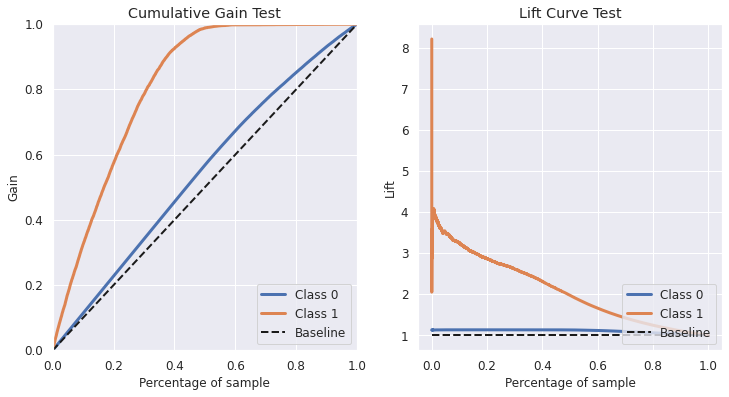

In [283]:
yhat_proba_val = model_xgb_tuned.predict_proba(x_validation)

fig, axs = plt.subplots(ncols= 2, figsize = (12,6))
skplt.metrics.plot_cumulative_gain(y_val, yhat_proba_val, ax=axs[0],title='Cumulative Gain Test');
skplt.metrics.plot_lift_curve(y_val, yhat_proba_val,ax=axs[1],title='Lift Curve Test')

# 9.0 Deploy to production

## 9.1 Saving Model

In [278]:
pickle.dump(model_xgb_tuned, open('/home/romulo/Documentos/health_insurance/health_insurance/src/models/model_xgb_tuned.pkl','wb'))

## 9.2 API Tester

In [57]:
import json

In [58]:
import requests

In [59]:
 # loading test dataset
#x_val_api = x_val_api.drop(['response'], axis=1)
df_test = x_val_api

In [60]:
 df_test = df_test.sample(10)

In [61]:
 # convert dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [62]:
 data

'[{"id": 268807, "gender": "Female", "age": 52, "driving_license": 1, "region_code": 28.0, "previously_insured": 0, "vehicle_age": "over_2_years", "vehicle_damage": 1, "annual_premium": 60012.0, "policy_sales_channel": 26.0, "vintage": 14}, {"id": 227484, "gender": "Female", "age": 58, "driving_license": 1, "region_code": 41.0, "previously_insured": 0, "vehicle_age": "between_1_and_2_year", "vehicle_damage": 1, "annual_premium": 22768.0, "policy_sales_channel": 26.0, "vintage": 180}, {"id": 373733, "gender": "Female", "age": 39, "driving_license": 1, "region_code": 41.0, "previously_insured": 1, "vehicle_age": "between_1_and_2_year", "vehicle_damage": 0, "annual_premium": 23801.0, "policy_sales_channel": 122.0, "vintage": 139}, {"id": 98612, "gender": "Male", "age": 62, "driving_license": 1, "region_code": 48.0, "previously_insured": 0, "vehicle_age": "over_2_years", "vehicle_damage": 1, "annual_premium": 2630.0, "policy_sales_channel": 157.0, "vintage": 291}, {"id": 288404, "gender": 

In [63]:
# save json in file
with open('data.json', 'w') as o:
    o.write(data)

# save json file in csv
data_json = pd.read_json('data.json')
data_json.to_csv('data.csv')

In [64]:
 # API Call
#url = 'http://0.0.0.0:5000/predict'
url = 'https://health-insurance-model-rf.herokuapp.com/predict'
header = {'Content-type': 'application/json' }

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

Status Code 200


In [65]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )
d1.sort_values( 'prediction', ascending=False ).head(10)

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,prediction
9,7185,0.139808,0.276923,1,0.188381,0,below_1_year,0,-0.104382,150.0,0.629758,0.056969
6,243902,0.104237,0.292308,1,0.188381,0,below_1_year,0,0.454667,26.0,0.795848,0.048894
5,28282,0.139808,0.184615,1,0.153074,0,below_1_year,0,0.228769,156.0,0.003460,0.048016
0,268807,0.104237,0.492308,1,0.188381,0,below_1_year,0,1.712860,26.0,0.013841,0.047329
3,98612,0.139808,0.646154,1,0.104636,0,below_1_year,0,-1.622828,157.0,0.972318,0.036521
1,227484,0.104237,0.584615,1,0.123899,0,below_1_year,0,-0.452181,26.0,0.588235,0.034756
7,3241,0.139808,0.107692,1,0.081586,0,below_1_year,0,0.210632,152.0,0.477509,0.027681
8,8107,0.139808,0.030769,1,0.066477,0,below_1_year,0,-1.622828,152.0,0.608997,0.025822
2,373733,0.104237,0.292308,1,0.123899,1,below_1_year,0,-0.392131,122.0,0.446367,0.000835
4,288404,0.104237,0.015385,1,0.078817,1,below_1_year,0,0.732650,152.0,0.975779,0.000554


## 9.3 Saving Client's List in CSV